In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pandas as pd
import nibabel as nib
import meshio
import torch
import warp as wp
wp.config.quiet = True

import matplotlib as mpl
import pyvista as pv

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [8]:
%autoreload
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
ds.load_metadata()
ex = next(ds.examples(
    subjects=['wss.1f5c74f0a55cbf9798d5fc0473d00a1c'],
    variant='2025-11-02',
    default_unit=1e-2,
    unit_policy='prefer_metadata',
))
pprint(ex, 3)

Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.1f5c74f0a55cbf9798d5fc0473d00a1c'
├── variant:  '2025-11-02'
├── paths:    dict(len=14)
|   ├── 'source_mesh':   PosixPath('../../data/ShapeNetSem/models-OBJ/models/1f5c74f0a55cbf9798d5fc0473d00a1c.obj')
|   ├── 'source_mask':   PosixPath('../../data/ShapeNetSem/models-binvox-solid/1f5c74f0a55cbf9798d5fc0473d00a1c.binvox')
|   ├── 'surface_mesh':  PosixPath('../../data/ShapeNetSem/2025-11-02/1f5c74f0a55cbf9798d5fc0473d00a1c/meshes/surface.xdmf')
|   ├── 'binary_mask':   PosixPath('../../data/ShapeNetSem/2025-11-02/1f5c74f0a55cbf9798d5fc0473d00a1c/masks/binary.nii.gz')
|   ├── 'region_mask':   PosixPath('../../data/ShapeNetSem/2025-11-02/1f5c74f0a55cbf9798d5fc0473d00a1c/masks/regions.nii.gz')
|   ├── 'volume_mesh':   PosixPath('../../data/ShapeNetSem/2025-11-02/1f5c74f0a55cbf9798d5fc0473d00a1c/meshes/volume.xdmf')
|   ├── 'material_mask': PosixPath('../../data/ShapeNetSem/2025-11-02/1f5c74f0a55cbf9798d5fc0473d00a1c/masks/material.nii

In [ ]:
project.preprocessi

In [ ]:
project.preprocessing.api.simulate_displacement_field(
    mesh_path=ex.paths['node_values'],
    input_mask_path=ex.paths['region_mask'],
    output_nodes_path=ex.paths['node_values_opt'],
    output_path=ex.paths['elastic_field_opt'],
    unit_m=ex.metadata['unit'],
    solver_kws=dict(reg_weight=1e-4),
    rasterize=True
)

In [59]:
%autoreload
metrics = project.preprocessing.api.optimize_elasticity_field(
    input_nodes_path=ex.paths['node_values'],
    input_mask_path=ex.paths['region_mask'],
    output_nodes_path=ex.paths['node_values_opt'],
    output_path=ex.paths['elastic_field_opt'],
    unit_m=ex.metadata['unit'],
    solver_kws=dict(reg_weight=1e-4),
    rasterize=True
)
metrics

Loading ../../data/ShapeNetSem/2025-11-02/1f5c74f0a55cbf9798d5fc0473d00a1c/meshes/node_values.xdmf
Loading ../../data/ShapeNetSem/2025-11-02/1f5c74f0a55cbf9798d5fc0473d00a1c/masks/regions.nii.gz
Optimizing elasticity to match observed displacement
Optimizing global parameter(s)
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	2.5086e+00 (nan)	3.4108e+00 (nan)	3.4108e+00 (nan)
1	2.4866e-03 (9.9901e-01)	3.4108e+00 (1.0000e+00)	3.4108e+00 (0.0000e+00)
Optimization converged
Optimizing local parameter(s)
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	2.4866e-03 (nan)	3.7375e+00 (nan)	3.7375e+00 (nan)
1	1.1841e-04 (9.5238e-01)	4.0152e+00 (1.0743e+00)	4.0152e+00 (2.2651e-01)
2	1.1532e-04 (2.6084e-02)	4.7667e+00 (1.2754e+00)	4.7667e+00 (5.3662e-01)
3	1.1407e-04 (1.0850e-02)	1.7840e+01 (4.7732e+00)	1.7840e+01 (3.1427e+00)
4	1.0420e-04 (8.6526e-02)	1.7778e+01 (4.7565e+00)	1.7778e+01 (5.6008e-02)
5	1.0271e-04 (1.4317e-02)	1.7824e+01 (4.7689e+00)	1.7824

{'u.norm': 0.1334837719026854,
 'u.rms': 0.19170947185182954,
 'u.rmse': 0.000789984391671199,
 'u.nrmse': 0.004119666860901416,
 'u.pcorr': 0.9999899422648311,
 'u.scorr': 0.9926580675155201,
 'E.norm': 4.043311223889628e+17,
 'E.rms': 1.7001150100776569e+19,
 'E.rmse': 1.7001150100776569e+19,
 'E.nrmse': 6837020717817715.0,
 'E.pcorr': -0.030254218722717437,
 'E.scorr': 0.5505795782156381,
 'res.norm': 0.10124177904144513,
 'res.rms': 0.1682062278153564}

Loading ../../data/ShapeNetSem/2025-11-02/1f5c74f0a55cbf9798d5fc0473d00a1c/fields/elasticity.nii.gz
Loading ../../data/ShapeNetSem/2025-11-02/1f5c74f0a55cbf9798d5fc0473d00a1c/fields/elasticity_opt.nii.gz


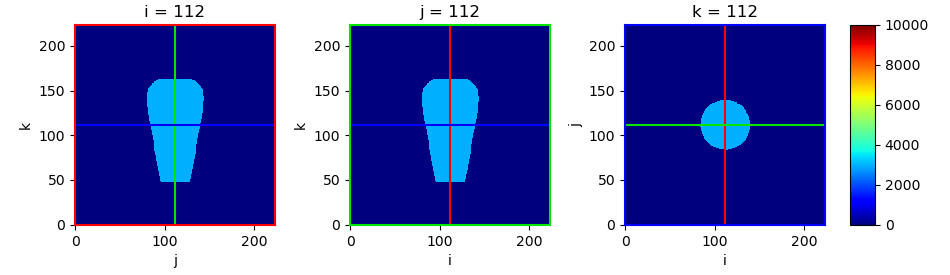

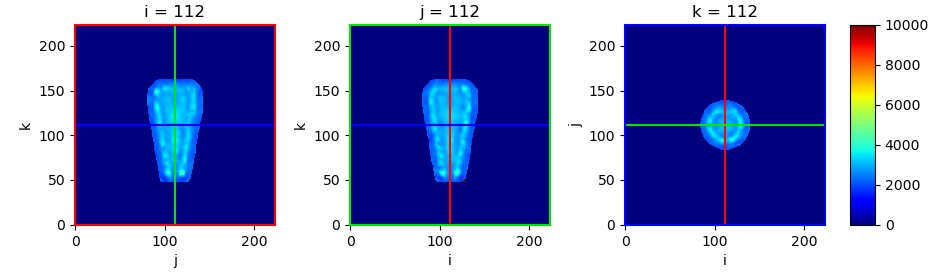

In [57]:
import project.visual.matplotlib

nifti = project.core.fileio.load_nibabel(ex.paths['elastic_field'])
_ = project.visual.matplotlib.show_image_slices(nifti.get_fdata(), cmap='jet', clim=(0, 1e4))

nifti = project.core.fileio.load_nibabel(ex.paths['elastic_field_opt'])
_ = project.visual.matplotlib.show_image_slices(nifti.get_fdata(), cmap='jet', clim=(0, 1e4))

In [55]:
mesh = project.core.fileio.load_meshio(ex.paths['node_values_opt'])
mesh = pv.wrap(mesh)
p = pv.Plotter(window_size=(400,400))
p.add_mesh(mesh, scalars='E_opt', cmap='jet', clim=(0,1e4))
p.show(jupyter_backend='trame')

Loading ../../data/ShapeNetSem/2025-11-02/1f5c74f0a55cbf9798d5fc0473d00a1c/meshes/node_values_opt.xdmf


2025-11-06 18:09:20.374 (8440.139s) [    14E8384A3200]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14e645720b10_0" src="https://ondemand.bridges2.p…

# Inverse optimization development

In [21]:
mesh_path = ex.paths['volume_mesh']
density_path = ex.paths['density_field']
elastic_path = ex.paths['elastic_field']
unit = ex.metadata['unit']
unit

0.0136197560186615

In [22]:
mesh = project.core.fileio.load_meshio(mesh_path)
density_nifti = project.core.fileio.load_nibabel(density_path)
elastic_nifti = project.core.fileio.load_nibabel(elastic_path)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/density.nii.gz
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/elasticity.nii.gz


In [8]:
affine_d = density_nifti.affine
affine_e = elastic_nifti.affine
np.allclose(affine_d, affine_e)

True

In [9]:
rho_field = density_nifti.get_fdata().astype(np.float32)
E_field = elastic_nifti.get_fdata().astype(np.float32)
rho_field.shape == E_field.shape

True

In [11]:
import project.core.transforms
pts_voxel = project.core.transforms.world_to_voxel_coords(mesh.points, affine_d)

In [12]:
tensor_kws = dict(dtype=torch.float32, device='cuda')
pts_tensor = torch.as_tensor(pts_voxel, **tensor_kws)
rho_tensor = torch.as_tensor(rho_field, **tensor_kws).unsqueeze(0)
E_tensor = torch.as_tensor(E_field, **tensor_kws).unsqueeze(0)
pts_tensor.shape, rho_tensor.shape, E_tensor.shape

(torch.Size([6846, 3]),
 torch.Size([1, 224, 224, 224]),
 torch.Size([1, 224, 224, 224]))

In [14]:
import project.core.interpolation
rho_nodes = project.core.interpolation.interpolate_image(rho_tensor, pts_tensor)
E_nodes = project.core.interpolation.interpolate_image(E_tensor, pts_tensor)
print(rho_nodes.mean())
print(E_nodes.mean())
rho_nodes.shape, E_nodes.shape

tensor(394.1529, device='cuda:0')
tensor(2411.2158, device='cuda:0')


(torch.Size([6846, 1]), torch.Size([6846, 1]))

In [15]:
nu_value = 0.4
mu_nodes, lam_nodes = project.core.transforms.compute_lame_parameters(E_nodes, nu_value)
bc_nodes = torch.zeros_like(pts_tensor, **tensor_kws)